# Отток клиентов банка

**Описание проекта:** нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, основываясь на исторических данных о поведении клиентов и расторжении договоров с банком.

**Результат:** модель с предельно большим значением *F1*-меры (минимум 0.59 на тестовой выборке).

# 1. Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, recall_score,
                             precision_recall_curve, roc_curve, roc_auc_score)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [3]:
customer_churn_data = pd.read_csv('/datasets/Churn.csv')

In [4]:
# ознакомимся со структурой датасета
customer_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
print(f"Количество полных дубликатов строк: {customer_churn_data.duplicated().sum()}")

Количество полных дубликатов строк: 0


В искомом датасете 10 тыс. объектов, каждый из которых соответствует одному клиенту банка, и 14 признаков. Полных дубликатов строк нет. В признаке 'Tenure' есть пропуски, не хватает 909 значений. Некоторые признаки не имеют практического значения — это 'RowNumber', 'CustomerId' и 'Surname'. Избавимся от них за ненадобностью.

In [6]:
customer_churn_data = customer_churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Целевой признак - 'Exited', является бинарным и означает факт ухода клиента. Будем решать задачу бинарной классификации, для чего, в первую очередь, обучим модель по алгоритму логистической регрессии. Данная модель хорошо подходит для решения подобных задач. В завершении сравним полученные результаты с результатами моделей обученных по алгоритму дерева решений и случайный лес и выберем лучшую по AUC-ROC.

Логистическая регрессия аналогична множественной линейной регрессии, за одним исключением — исход является бинарным. Не вдаваясь в математические подробности можно сказать, что суть алгоритма заключается в предсказании вероятности отнесения объекта к положительному классу и сопутствующим этому оптимизациям. Если вероятность оказывается выше пороговой, то объект относится к классу 1 (положительному), если ниже пороговой, то к классу 0 (отрицательному). За счет этого результаты обученной модели чувствительны к дисбалансу классов в обучающей выборке, поэтому искомые данные должны быть сбалансированы на этапе предобработки.

Для банка "вероятностный подход" к определению класса объекта может быть интересен, так как если умножить полученную в результате работы модели вероятность на доход с конкретного клиента, то можно получить математическое ожидание потерь от ухода конкретного клиента, что в свою очередь может помочь в оценке эффективности и целесообразности маркетинговых активностей.   

Из свойств алгоритма следует, что:
* все X должны быть количественными данными;
* среди X не должно быть пропущенных значений;
* обучающая выборка должна быть сбалансирована (на сколько это возможно).

Поэтому базовым этапом в предобработке датасета для логистической регрессии будет:
* предобработка количественных признаков - исследование распределения признаков, их масштабирование, стандартизация или нормализация,  удаление или интерпретация пропущенных значений и т.д;
* кодирование категориальных признаков;
* балансирование классов в обучающей выборке. 

### 1.1 Обзор количественных признаков
Качество обучающего набора данных окажет влияние на качество обученной модели. Исследуя выборку мы ожидаем, что сделанные по ней выводы можно экстраполировать на всю генеральную совокупность. По сути тем же экстраполированием выученных закономерностей занимается и модель на новых данных. Получается, на каком распределении она обучилась, с таким она и будет лучше работать. Вероятно поэтому, лучше обучать и/или валидировать модель на данных распределенных так же как и ожидаемые новые данные (которые будут поступать в модель после обучения).

Генеральной совокупностью будут все клиенты банка. Ожидается, что признаки генеральной совокупности могут быть распределены нормально, а значит большинство значений будет разбросано вокруг среднего генеральной совокупности. Желательно, чтобы распределение выборочной совокупности было похожим, так у нас будет больше уверенности в том, что модель выявит нужные закономерности.

Для начала изучим дескриптивные статистики количественных признаков. По ним сделаем примерные выводы о распределении признаков.

In [7]:
customer_churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Заметно, что минимальные и максимальные значения сильно разнятся от признака к признаку — есть признаки измеряющиеся однозначными числами и шестизначными. Это может негативно отразиться на определении веса признаков, важные признаки могут оказаться недооцененными моделью. Чтобы этого избежать нужно будет нормализовать, либо стандартизировать значения.

Некоторые попавшие в таблицу признаки - 'HasCrCard', 'IsActiveMember' и 'Exited', являются категориальными (бинарными). Остальные признаки распределены достаточно симметрично и "кучно" - средние значения практически совпадают с медианой, и если судить по стандартному отклонению значения слабо отклоняется от средних. Исключением является признак 'Balance', тут наблюдаем правостороннюю асимметрию — среднее значительно меньше медианы. В данном признаке очень много нулей из-за чего мы имеем как бы две вершины распределения. Можно попробовать исправить это обработав нули как пропуски, либо преобразовав данный признак в категориальный (отсутствие/присутствие баланса и интервалы по квартилям распределения).

In [8]:
customer_churn_data['has_balance'] = np.where(customer_churn_data['Balance'] > 0, 1, 0)

In [9]:
def group_by_balance(x, data):
    threshold = data.quantile([0.25,0.5,0.75]).values
    if x > threshold[2]:
        result = f"> {round(threshold[2])}"
    elif x > threshold[1]:
        result = f"{round(threshold[1])} < x < {round(threshold[2])}"
    else:
        result = f"< {round(threshold[1])}"
    return result

In [10]:
%%time

customer_churn_data['balance_group'] = customer_churn_data.apply(
    lambda x: group_by_balance(x['Balance'], customer_churn_data['Balance']), axis=1)

CPU times: user 16.6 s, sys: 16.8 ms, total: 16.6 s
Wall time: 16.9 s


In [11]:
customer_churn_data = customer_churn_data.drop(['Balance'], axis=1)

### 1.2 Исследование "выбросов"
Наличие "выбросов" в данных может ухудшить параметры настраиваемой модели, которая будет пытаться объяснить все наблюдения, включая нетипичные. В то же время есть риск неправильно определить и отфильтровать выбросы (перепутать выбросы и аномалии), что в итоге может привести к переобучению модели. Поэтому нужно делать это осторожно. Для фильтрации выбросов существуют разные подходы — можно искать выбросы в одном признаке или в нескольких признаках сразу.

Наиболее простые варианты:
- предположить наличие выбросов можно по коэффициенту эксцесса (для симметричных распределений),
- или стандартизировать значения и воспользоваться правилом "3 сигм" для нормальных распределений,
- можно ограничиться поиском экстремальных значений по боксплоту.

Воспользуюсь третьим вариантом. Для того, чтобы боксплоты на одной диаграмме были сопоставимы стандартизирую их шкалы.

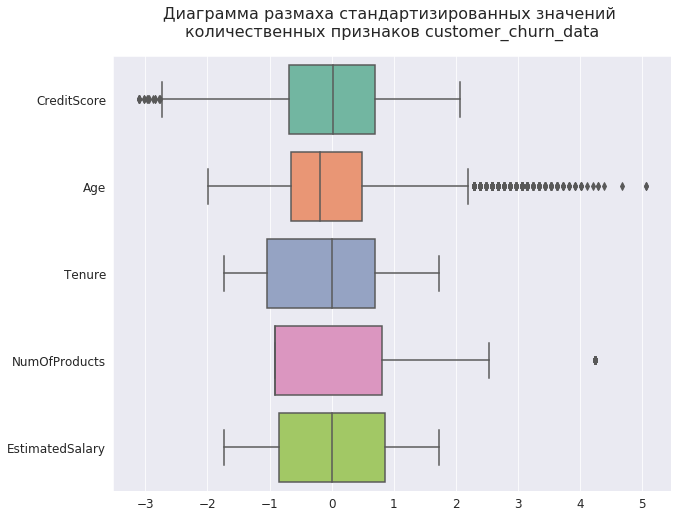

In [12]:
# определим количественные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary'] #'Balance'

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10, 8))

# стандартизируем шкалы для наглядности

sns.boxplot(data=[(customer_churn_data[x] - customer_churn_data[x].mean()) / 
                  customer_churn_data[x].std() for x in customer_churn_data[numeric]],
            orient="h", palette="Set2", ax=ax)

ax.set_yticklabels(list(customer_churn_data[numeric].columns))
ax.set_title("Диаграмма размаха стандартизированных значений \n\
количественных признаков customer_churn_data", size=16, pad=20)
ax.tick_params(labelsize=12)

plt.show()

По диаграмме размаха заметны экстремальные значения признаков 'CreditScore', 'Age' и 'NumOfProducts'. В первом случае наблюдаем значения на отметке примерно "-3 сигмы". Во втором случае, значение признака может отклоняться более чем на "3 сигмы" (до "5 сигм"). В третьем случае, выделилось максимальное значение. Изучим объекты с соответствующими значениями признаков  подробнее.

In [13]:
# отфильтруем объекты отклоняющиеся от среднего более чем на -2.7 сигмы
(customer_churn_data.query("(CreditScore - CreditScore.mean()) / CreditScore.std() < -2.7"
                          ).sort_values(by='CreditScore'))

,CreditScore,Geography,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,has_balance,balance_group
9624,350,France,Female,40,0.0,1,1,1,172321.21,1,1,97199 < x < 127644
8762,350,France,Female,60,3.0,1,0,0,113796.15,1,0,< 97199
1631,350,Spain,Male,54,1.0,1,1,1,191973.49,1,1,> 127644
1838,350,Germany,Male,39,0.0,2,0,0,123602.11,1,1,97199 < x < 127644
8723,350,France,Male,51,10.0,1,1,1,125823.79,1,0,< 97199
2473,351,Germany,Female,57,4.0,1,1,0,169621.69,1,1,> 127644
1962,358,Spain,Female,52,8.0,3,1,0,141959.11,1,1,> 127644
1405,359,France,Female,44,NaN,1,1,0,146955.71,1,1,> 127644
1193,363,Spain,Female,28,6.0,3,1,0,100615.14,1,1,> 127644
2579,365,Germany,Male,30,0.0,1,1,0,81537.85,1,1,> 127644


Единственное, что бросается в глаза, так это то, что все клиенты с 'CreditScore' близким к "-3 сигмы" покинули банк ('Exited' = 1). Но, несмотря на это, баланс счета у большинства положительный. Также почти у всех предполагаемая зарплата выше выборочного среднего. Наводит на мысль, что кредитный рейтинг не в первую очередь зависит от предполагаемого дохода, а клиенты моги уйти из-за того, что не получили желаемый кредит (из-за своего рейтинга), либо потому что им хватает собственного дохода. Эти объекты могут представлять ценность для исследования, поэтому я не буду удалять их как выбросы.

In [14]:
# отфильтруем объекты отклоняющиеся от среднего более чем на 2.2 сигмы
customer_churn_data.query("(Age - Age.mean()) / Age.std() > 2.2").describe()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,has_balance
count,411.000000,411.000000,384.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,656.150852,68.350365,4.958333,1.513382,0.698297,0.817518,97522.942141,0.228710,0.632603
std,96.429813,5.459283,3.014904,0.585759,0.459557,0.386712,57743.252981,0.420514,0.482683
min,408.000000,62.000000,0.000000,1.000000,0.000000,0.000000,502.700000,0.000000,0.000000
25%,592.500000,64.000000,2.000000,1.000000,0.000000,1.000000,48407.890000,0.000000,0.000000
50%,656.000000,67.000000,5.000000,1.000000,1.000000,1.000000,96399.670000,0.000000,1.000000
75%,724.500000,72.000000,8.000000,2.000000,1.000000,1.000000,145873.755000,0.000000,1.000000
max,850.000000,92.000000,10.000000,4.000000,1.000000,1.000000,199493.380000,1.000000,1.000000


Так как объектов более 100, рассмотрим описательные статистики. В данную группу попали клиенты в возрасте 62-92 года. Гипотетически люди могут иметь такой возраст, данные значения вряд ли являются ошибочными (в выборке жители европейских стран). Почти все клиенты этой возрастной категории являются активными пользователями ('IsActiveMember' = 1). Примерно поровну клиентов с доходом выше и ниже среднего по выборке ('EstimatedSalary').

In [15]:
# отфильтруем объекты отклоняющиеся от среднего более чем на 3 сигмы
(customer_churn_data.query("(NumOfProducts - NumOfProducts.mean()) / NumOfProducts.std() > 3"
                          ).sort_values(by='EstimatedSalary')).describe()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,has_balance
count,60.000000,60.000000,56.000000,60.0,60.000000,60.000000,60.000000,60.0,60.000000
mean,653.583333,45.683333,5.232143,4.0,0.683333,0.483333,104763.723333,1.0,0.766667
std,101.265600,8.619040,2.935619,0.0,0.469102,0.503939,57526.494114,0.0,0.426522
min,376.000000,29.000000,1.000000,4.0,0.000000,0.000000,5669.310000,1.0,0.000000
25%,595.000000,40.000000,2.750000,4.0,0.000000,0.000000,62033.390000,1.0,1.000000
50%,643.000000,45.000000,5.000000,4.0,1.000000,0.000000,112163.105000,1.0,1.000000
75%,708.000000,50.250000,8.000000,4.0,1.000000,1.000000,139371.955000,1.0,1.000000
max,850.000000,68.000000,10.000000,4.0,1.000000,1.000000,198874.520000,1.0,1.000000


В данную группу попали только ушедшие клиенты ('Exited' = 1), которые пользовались всеми четырьмя продуктами банка ('NumOfProducts' = 4). Большая часть имеет нормальный кредитный рейтинг ('CreditScore') и указали минимум один объект недвижимости ('Tenure'). Примерно поровну из них были активными пользователями ('IsActiveMember').

Можно будет обучить модель дважды — на данных с/без обработки "выбросов". Оценить влияние этих значений на качество модели. Так как возможен дисбаланс групп в целевом признаке, нельзя удалять объекты целиком. Вместо этого можно обработать "выбросы" как пропущенные значения.

### 1.3 Обзор и кодирование категориальных признаков

В искомом датасете есть четыре бинарных признака - 'HasCrCard', 'IsActiveMember', has_balance и 'Exited' (один из них целевой признак) и еще три категориальных признака - 'Geography', 'Gender' и 'balance_group'. Для начала изучим классы категориальных признаков и их численность.

In [16]:
for column in ['HasCrCard', 'IsActiveMember', 'Exited', 'Geography',
               'Gender', 'has_balance', 'balance_group']:
    print(f"Название признака: {customer_churn_data[column].name}")
    display((customer_churn_data[column]
             .value_counts(normalize=True)
             .map(lambda x: '{:,.2%}'.format(x))))
    print("--------------------------------------------------")

Название признака: HasCrCard


1    70.55%
0    29.45%
Name: HasCrCard, dtype: object

--------------------------------------------------
Название признака: IsActiveMember


1    51.51%
0    48.49%
Name: IsActiveMember, dtype: object

--------------------------------------------------
Название признака: Exited


0    79.63%
1    20.37%
Name: Exited, dtype: object

--------------------------------------------------
Название признака: Geography


France     50.14%
Germany    25.09%
Spain      24.77%
Name: Geography, dtype: object

--------------------------------------------------
Название признака: Gender


Male      54.57%
Female    45.43%
Name: Gender, dtype: object

--------------------------------------------------
Название признака: has_balance


1    63.83%
0    36.17%
Name: has_balance, dtype: object

--------------------------------------------------
Название признака: balance_group


< 97199               50.00%
97199 < x < 127644    25.00%
> 127644              25.00%
Name: balance_group, dtype: object

--------------------------------------------------


Дадим короткую характеристику каждого из пунктов:
* Почти все клиенты выборки имеют кредитные карты.
* Половина клиентов являются активными пользователями.
* Около 20 процентов клиентов в выборке являются ушедшими, т.о наблюдаем дисбаланс классов целевом признаке.
* География клиентов распространяется на три страны — Францию, Германию и Испанию.
* В выборке практически поровну мужчин и женщин.

Для логистической регрессии будем использовать технику прямого кодирования (One-Hot Encoding). Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [17]:
# укажем drop_first, чтобы избежать дамми-ловушки
data_ohe = pd.get_dummies(customer_churn_data, drop_first=True)

data_ohe

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,has_balance,Geography_Germany,Geography_Spain,Gender_Male,balance_group_< 97199,balance_group_> 127644
0,619,42,2.0,1,1,1,101348.88,1,0,0,0,0,1,0
1,608,41,1.0,1,0,1,112542.58,0,1,0,1,0,1,0
2,502,42,8.0,3,1,0,113931.57,1,1,0,0,0,0,1
3,699,39,1.0,2,0,0,93826.63,0,0,0,0,0,1,0
4,850,43,2.0,1,1,1,79084.10,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,2,1,0,96270.64,0,0,0,0,1,1,0
9996,516,35,10.0,1,1,1,101699.77,0,1,0,0,1,1,0
9997,709,36,7.0,1,0,1,42085.58,1,0,0,0,0,1,0
9998,772,42,3.0,2,1,0,92888.52,1,1,1,0,1,1,0


### 1.4 Разделение данных на выборки

Сначала разделим датасет на две части по признакам - в одном оставим целевой признак, а в другом обучающие признаки.

In [18]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

Разобьём полученные датасеты на две выборки — обучающую и тестовую. Кросс-валидация будет проводиться на этапе подбора гиперпараметров.

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=321)

Проверим полученные выборки.

In [20]:
print("Обучающая выборка")
print("Размер 'features_train':", features_train.shape)
print("Размер 'target_train':", target_train.shape)
print()
print("Тестовая выборка")
print("Размер 'features_test':", features_test.shape)
print("Размер 'target_test':", target_test.shape)

Обучающая выборка
Размер 'features_train': (7500, 13)
Размер 'target_train': (7500,)

Тестовая выборка
Размер 'features_test': (2500, 13)
Размер 'target_test': (2500,)


### 1.5. Обработка пропущенных значений

Гипотетически, пропуски можно обработать следующими способами:
* заменить пропуски на 0 (данный признак давать вклад в предсказание для данного объекта не будет);
* преобразовать признак в категориальный, а затем закодировать по ohe;
* заполнить пропуски выборочными статистиками соответствующего признака (среднее, медиана и т.д.), полагая, что взаимосвязь между признаками отсутствует (каждый пропущенный признак будет давать такой же вклад, как и значение, выбранной меры центральной тенденции, признака в датасете); 
* заполнить неизвестные значения с учетом корреляции между переменными или меры близости между наблюдениями.

Рассмотрим подробнее признак 'Tenure', в котором наблюдаются пропущенные значения. 

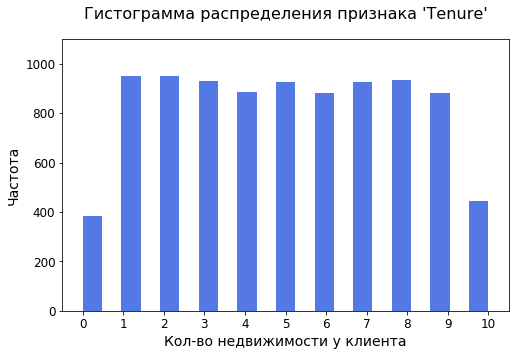

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.distplot(customer_churn_data.query('Tenure.notnull()')['Tenure'],
             hist_kws = {'color': 'royalblue', 'alpha': 0.9},
             kde=False, ax=ax)

ax.set_title("Гистограмма распределения признака 'Tenure'", size=16, pad=20)
ax.set_xticks(list(range(0, int(customer_churn_data['Tenure'].max() + 1),1)))
ax.set_xlabel("Кол-во недвижимости у клиента", fontsize=14)
ax.set_ylabel("Частота", fontsize=14)
ax.set_ylim(0, 1100)
ax.tick_params(labelsize=12)

plt.show()

Данный признак дискретный, размах значений небольшой (от 0 до 10). Почти все значения являются модами, либо очень близки к ним. Можно было бы представить данный признак в виде категориального. Просто заменить пропуски нулями мы не можем, потому что данное значение имеет в этом признаке другое значение (отсутствие недвижимости). Можем заменить пропуски средними значениями, которые после стандартизации будут равны нулю и не внесут вклада в предсказание целевого признака для конкретного объекта. Для того, чтобы сделать это максимально точно, заполним пропуски для каждой из полученных выборок.

In [22]:
# заменим пропуски в обучающей выборке
features_train.fillna(features_train['Tenure'].mean(), inplace=True)

In [23]:
# заменим пропуски в тестовой выборке
features_test.fillna(features_test['Tenure'].mean(), inplace=True)

### 1.6 Масштабирование данных

Как уже было отмечено ранее значения признаков сильно разнятся, поэтому признаки необходимо масштабировать. Масштабируем количественные признаки стандартизировав их.

In [24]:
scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])

features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

### Заключение по п. 1 "Подготовка данных"

На подготовительном этапе мы ознакомились с данными и подготовили их для обучения модели логистической регрессии:
* преобразовали категориальные признаки техникой прямого кодирования;
* проверили данные на выбросы, выявив и объяснив экстремальные значения;
* нашли и интерпретировали пропущенные значения;
* масштабировали значения признаков;
* выявили дисбаланс классов целевого признака;
* разделили искомый датасет на обучающую и тестовую выборки. 

# 2. Исследование задачи

На втором этапе предстоит исследовать баланс классов — обучить модель без учета дисбаланса классов, оценить адекватность такой модели, сделать соответствующие выводы.

Ранее, на подготовительном этапе п. 1.3, мы заметили, что в целевом признаке классы представлены неравномерно - в искомом датасете около 80% объектов относятся к классу "0" и только 20% к классу "1". Рассмотрим как распределены признаки в двух этих классах в обучающей выборке.

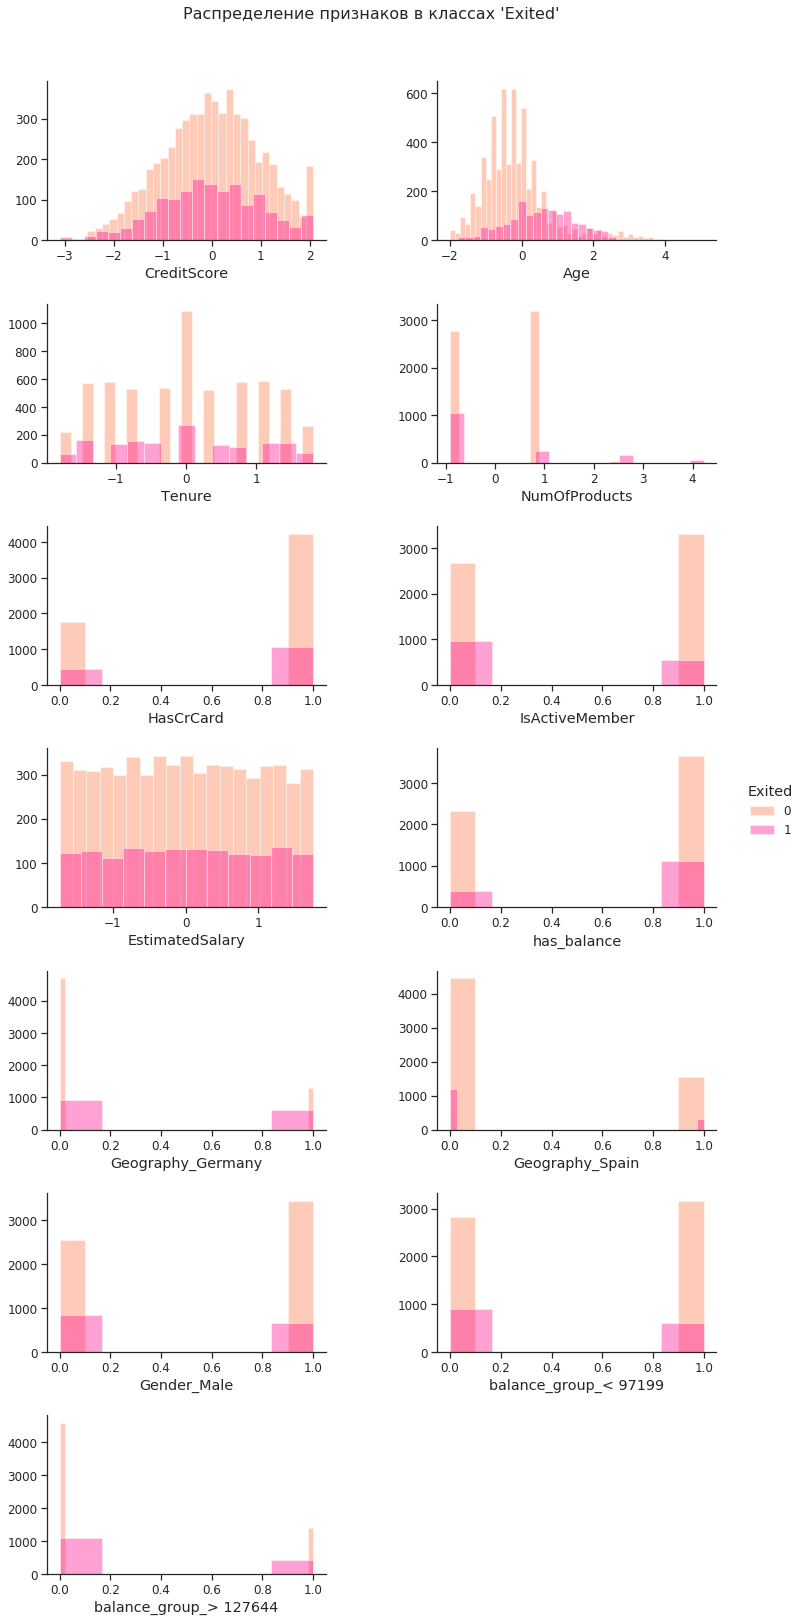

In [25]:
sns.set(style="ticks", font_scale=1.2)

fig = plt.figure(figsize=(6*2, 4*len(features_train.columns)))
gs = fig.add_gridspec(len(features_train.columns), 2)

for i in range(len(features_train.columns)):
    ax = fig.add_subplot(gs[int(i/2), i%2])
    ax.tick_params(labelsize=12)
    sns.distplot(features_train[target_train == 0][features_train.columns[i]],
                 kde=False, color="coral")
    sns.distplot(features_train[target_train == 1][features_train.columns[i]],
                 kde=False, color="deeppink")
    sns.despine()

fig.suptitle("Распределение признаков в классах 'Exited'", fontsize=16, y=0.90)
fig.legend(labels=['0','1'], loc='center right', frameon=False,
           ncol=1, fontsize=12, title='Exited')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

Заметен дисбаланс классов. В классах признаки распределены похожим образом, но небольшие отличия все же есть:
* среди ушедших клиентов больше тех кто в возрасте;
* среди ушедших клиентов банка чаще встречаются те, кто использовал более двух продуктов банка;
* при этом, в сравнении с действующими клиентами банка, ушедшие реже являлись активными клиентами;
* среди ушедших клиентов больше женщин.

Попробуем обучить модель на этих данных, не прибегая к балансировке классов целевого признака. Предполагается, что модель будет плохо предсказывать положительный класс.

In [26]:
def get_cv_scores(model, x, y):
    cv = cross_validate(model,
        x, y, scoring='f1', cv=5)
    cv_mean = round(np.mean(cv['test_score']), 2)
    cv_std = round(np.std(cv['test_score']), 4)
    return {'cv mean': cv_mean, 'std': cv_std}

In [27]:
disbalance_model = LogisticRegression(random_state=123, solver='liblinear')

In [28]:
%%time

print("mean f1-score: {cv mean}, std: {std}".format(
    **get_cv_scores(disbalance_model, features_train, target_train)))

mean f1-score: 0.31, std: 0.0072
CPU times: user 516 ms, sys: 421 ms, total: 938 ms
Wall time: 914 ms


Оценим эффективность модели на тестовой выборке.

In [29]:
%%time

disbalance_model.fit(features_train, target_train)
disbalance_predicted = disbalance_model.predict(features_test)
disbalance_model_probas = disbalance_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, disbalance_model_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, disbalance_predicted), 2), auc_roc))

F1 = 0.32, AUC = 0.77
CPU times: user 57.1 ms, sys: 84.6 ms, total: 142 ms
Wall time: 130 ms


Значение F1-меры ближе к нулю чем к единице, значит качество модели низкое. Однако AUC модели выглдит более оптимистично. Попробуем разобраться почему так произошло. Для этого представим графически метрику ROC-AUC и сравним ее с PR-кривой.

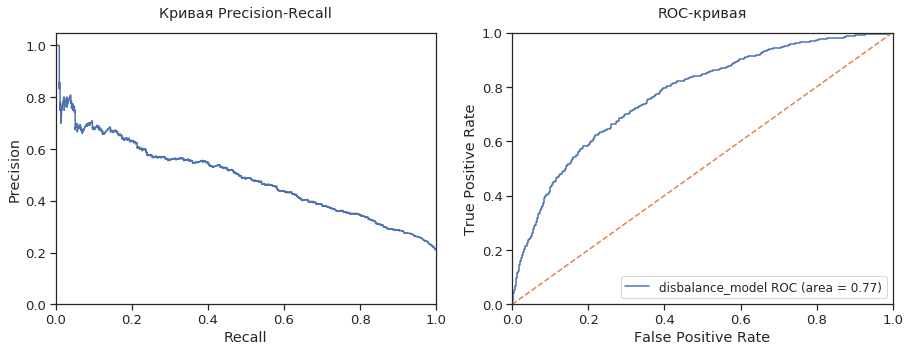

In [30]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 2)

# кривая Precision-Recall
ax1 = fig.add_subplot(gs[0, 0])
precision, recall, thresholds = precision_recall_curve(target_test, disbalance_model_probas[:, 1])
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall', pad=15)

# ROC-кривая
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, thresholds = roc_curve(target_test, disbalance_model_probas[:, 1])
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('disbalance_model', auc_roc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая', pad=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')

plt.show()

На диаграмме Precision-Recall кривая должна стремиться к правому верхнему углу, что будет означать что модель находит максимальное количество объектов положительного класса и при этом делает это достаточно точно. В нашем случае заметно, что при увеличении полноты точность снижается. Модель плохо предсказывает объекты положительного класса и это выливается в низкое значение F1-меры (т.к она среднее гармоническое двух этих метрик). 

По ROC-кривой эффективный классификатор стремится к левому верхнему углу и правильно идентифицирует много единиц, без неправильной классификации многих нулей как единиц, т.е учитывает соотношение истинных и ложных срабатываний. Во-первых, на сколько понимаю, в случае дисбаланса классов модель будет плохо предсказывать объекты положительного класса, а значит ложных срабатываний (FPR) может быть мало и за счет этого модель может получить более высокую оценку. Во-вторых, когда в целевом признаке есть редкий класс (обычно это положительный класс), улучшение предсказания этого класса для нас важнее, чем снижение числа ложных срабатываний (FP). Исходя из этого оценка несбалансированной модели по ROC выглядит менее оправданной. Решать проблему плохого предсказания редкого класса изменяя порог TPR/FPR не так удобно как в случае с Precision/Recall.

Заглянем внутрь полученной оценки и посмотрим, в определении какой из групп модель чаще допускала ошибки. Матрицу ошибок получим применив метод ```confusion_matrix```. Для отображения матрицы в виде графика, из одного руководства, была позаимствована и немного упрощена функция ```plot_confusion_matrix```.

In [31]:
# функция принимает результат работы метода confusion_matrix и наглядно визуализирует его
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Target')
    plt.xlabel('Predicted')

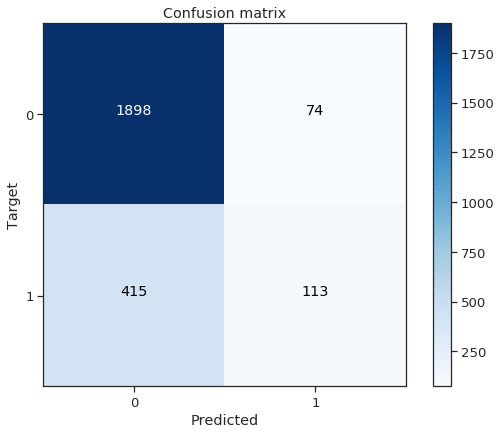

In [32]:
# матрица ошибок по предсказанию несбалансированной модели
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, disbalance_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Как и ожидалось тестовая модель плохо предсказывает положительный класс - правильные ответы получены только для 21% объектов. Такую модель нельзя использовать, необходимо произвести балансировку классов.

# 3. Борьба с дисбалансом
### 3.1 Логистическая регрессия

Классы несбалансированны, когда их соотношение далеко от 1:1. Баланс классов наблюдается, если их количество примерно равно. Для некоторых моделей машинного обучения баланс классов является одним из критичных условий, оказывающих влияние на итоговое качество модели.

С дисбалансом классов можно бороться разными способами, например изменить вес или использовать разные стратегии сэмплинга классов. Так как продуктом логистической регрессии является вероятность отнесения объекта к одному из классов, то изменяя порог отсечения можно попытаться  улучшить качество предсказания редкого класса. Попробуем применить данные методы и улучшить качество модели.

Алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. Если важно указать, что какие-то объекты важнее, их классу присваивается вес. В алгоритме логистической регрессии в библиотеке sklearn есть аргумент ```class_weight```. По умолчанию он равен ```None```, т. е. классы равнозначны. Если указать ```class_weight='balanced'```, больший вес будет у редкого класса. Обучим модель с указанием этого аргумента и оценим как изменилось качество модели.

In [33]:
balance_model = LogisticRegression(solver='liblinear',
                                   class_weight='balanced',
                                   random_state=123)

In [34]:
%%time

print("mean f1-score: {cv mean}, std: {std}".format(
    **get_cv_scores(balance_model, features_train, target_train)))

mean f1-score: 0.49, std: 0.0199
CPU times: user 363 ms, sys: 468 ms, total: 831 ms
Wall time: 801 ms


Оценим эффективность модели на тестовой выборке.

In [35]:
%%time

balance_model.fit(features_train, target_train)
balance_predicted = balance_model.predict(features_test)
balance_model_probas = balance_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, balance_model_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, balance_predicted), 2), auc_roc))

F1 = 0.50, AUC = 0.77
CPU times: user 79.6 ms, sys: 102 ms, total: 181 ms
Wall time: 198 ms


Качество модели улучшилось, но значение F1-меры все еще не дотягивает до требуемого минимума в 0.59. Рассмотрим матрицу ошибок сбалансированной модели.

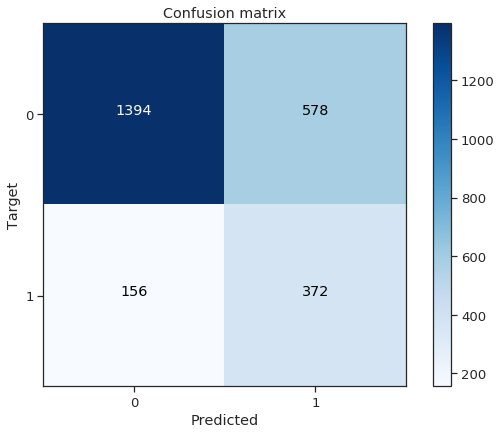

In [36]:
# матрица ошибок по предсказанию сбалансированной модели
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, balance_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Модель действительно сбалансировалась — стала лучше предсказывать объекты класса "1", но и потеряла в качестве предсказания объектов класса "0" (ложных срабатываний стало заметно больше).

Попробуем управляя пороговым значением искусственно завысить вероятность идентификации редкого класса. Известно, что по умолчанию порог отсечения равняется 0.5. Снизим порог, т.о. отнесем к положительному классу объекты с вероятностью положительного класса менее 0.5. Переберем значения в цикле, посмотрим как меняются значения точности, полноты и F1-меры.

In [37]:
%%time

model = LogisticRegression(random_state=567).fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.5, 0., -0.02):
    predicted_test = probabilities_one_valid > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.2f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test)))

Порог = 0.50 | Точность = 0.604, Полнота = 0.214, F1 = 0.32
Порог = 0.48 | Точность = 0.601, Полнота = 0.237, F1 = 0.34
Порог = 0.46 | Точность = 0.572, Полнота = 0.256, F1 = 0.35
Порог = 0.44 | Точность = 0.565, Полнота = 0.288, F1 = 0.38
Порог = 0.42 | Точность = 0.561, Полнота = 0.314, F1 = 0.40
Порог = 0.40 | Точность = 0.557, Полнота = 0.354, F1 = 0.43
Порог = 0.38 | Точность = 0.551, Полнота = 0.386, F1 = 0.45
Порог = 0.36 | Точность = 0.533, Полнота = 0.411, F1 = 0.46
Порог = 0.34 | Точность = 0.528, Полнота = 0.445, F1 = 0.48
Порог = 0.32 | Точность = 0.505, Полнота = 0.479, F1 = 0.49
Порог = 0.30 | Точность = 0.481, Полнота = 0.517, F1 = 0.50
Порог = 0.28 | Точность = 0.465, Полнота = 0.551, F1 = 0.50
Порог = 0.26 | Точность = 0.441, Полнота = 0.585, F1 = 0.50
Порог = 0.24 | Точность = 0.424, Полнота = 0.627, F1 = 0.51
Порог = 0.22 | Точность = 0.399, Полнота = 0.663, F1 = 0.50
Порог = 0.20 | Точность = 0.385, Полнота = 0.701, F1 = 0.50
Порог = 0.18 | Точность = 0.361, Полнота

При снижении порогового значения мы увеличиваем кол-во объектов положительного класса. При этом увеличивается кол-во ложно-положительных объектов (точность снижается), но также мы определяем больше реальных объектов положительного класса (полнота увеличивается). В случаях, когда для нас критично определить как можно больше реальнох объектов положительного класса (в нашем случае ушедших клиентов) это может быть оправдано если удержание выгоднее, чем привлечение новых. Затраты на ложно-положительные объекты не должны быть высокими.

Если ориентироваться на вывод выше, то если мы снизим порог до 0.2, то сможем выявить 70% уходящих пользователей. Однако при этом около 60% будут ложно-положительными. Оптимальное значение f1-меры в 0.51 достигается при пороге вероятности равному 0.26. Это значит, что все объекты имеющие вероятность положительного класа выше этого значения будут отнесены к этому классу. 

Попробуем потюнить гиперпараметры модели.

In [38]:
penalty = ['l2', 'l1']
C = np.logspace(-2, .5, num=4)
solver = ['liblinear']
class_weight = [None, "balanced"]

log_grid = {'penalty': penalty,
            'C': C,
            'solver': solver,
            'class_weight': class_weight,
           }

print(log_grid)

{'penalty': ['l2', 'l1'], 'C': array([0.01      , 0.06812921, 0.46415888, 3.16227766]), 'solver': ['liblinear'], 'class_weight': [None, 'balanced']}


In [39]:
log_test = LogisticRegression()

In [40]:
log_random = RandomizedSearchCV(estimator=log_test, scoring="f1",
    param_distributions=log_grid, verbose=2, refit="f1",
    cv=5, random_state=123, n_jobs=-1)

log_random.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616 
[CV]  solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616, total=   0.1s
[CV] solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616, total=   0.2s
[CV] solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616 
[CV]  solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616, total=   0.2s
[CV] solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616 
[CV]  solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616, total=   0.2s
[CV] solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616 
[CV]  solver=liblinear, penalty=l1, class_weight=balanced, C=0.06812920690579616, total=   0.2s
[CV] solver=liblinear, penalty=l2, class_weight=balanced, C=0.464158883361278 
[CV]  solver=liblinear, penalty=l2, class_weight=balanced, C=0.464158883361278, total=   0.2s
[CV] solver=liblinear, penalty=l2, class_weight=balanced, C=0.464158883361278 
[CV]  solver=liblinear, penalty=l2, class_weight=balanced, C=0.464158883361278, total=   0.2s
[CV] solver=liblinear, pena

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([0.01      , 0.06812921, 0.46415888, 3.16227766]),
                                        'class_weight': [None, 'balanced'],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['liblinear']},
                   random_state=123, refit='f1', scoring='f1', verbose=2)

In [41]:
print("best cv f1-score: ", round(log_random.best_score_, 2))

best cv f1-score:  0.51


In [42]:
print("best params:")
log_random.best_params_

best params:


{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.01}

In [43]:
%%time

log_tune = LogisticRegression(**log_random.best_params_, random_state=234
                             ).fit(features_train, target_train)

CPU times: user 17.7 ms, sys: 304 µs, total: 18 ms
Wall time: 22.1 ms


Оценим эффективность модели на тестовой выборке.

In [44]:
%%time

log_tune_predicted = log_tune.predict(features_test)
log_tune_probas = log_tune.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, log_tune_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, log_tune_predicted), 2), auc_roc))

F1 = 0.51, AUC = 0.77
CPU times: user 24.3 ms, sys: 56.5 ms, total: 80.8 ms
Wall time: 90.9 ms


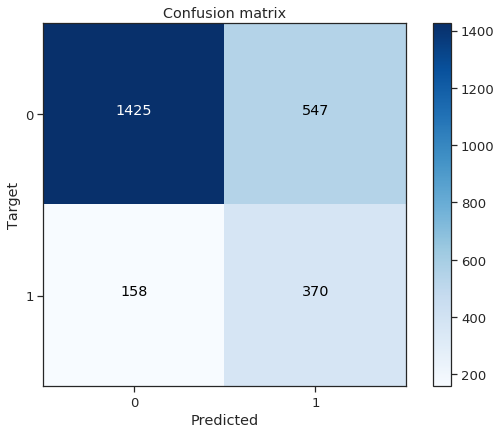

In [45]:
# матрица ошибок по предсказанию сбалансированной модели
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, log_tune_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Качество модели не улучшилось. Попробуем решить проблему редкости класса "1" еще одним способом, используя техники ресэмплинга.

**Оверсемплинг:**

In [46]:
%%time

oversample_pipeline = make_pipeline(RandomOverSampler(random_state=123), 
                                    LogisticRegression(solver='liblinear',
                                                       penalty='l1',
                                                       C=0.01,
                                                       random_state=345)
                                   )

log_oversample_score = cross_validate(oversample_pipeline, features_train,
                                      target_train, scoring='f1', cv=5)

print("best cv f1-score: ", round(log_oversample_score['test_score'].max(), 2))

best cv f1-score:  0.54
CPU times: user 394 ms, sys: 474 ms, total: 868 ms
Wall time: 856 ms


Оценим эффективность модели на тестовой выборке.

In [47]:
%%time

oversample_predicted = oversample_pipeline.fit(features_train, target_train
                                              ).predict(features_test)
oversample_probas = oversample_pipeline.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, oversample_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, oversample_predicted), 2), auc_roc))

F1 = 0.51, AUC = 0.77
CPU times: user 99.4 ms, sys: 123 ms, total: 222 ms
Wall time: 204 ms


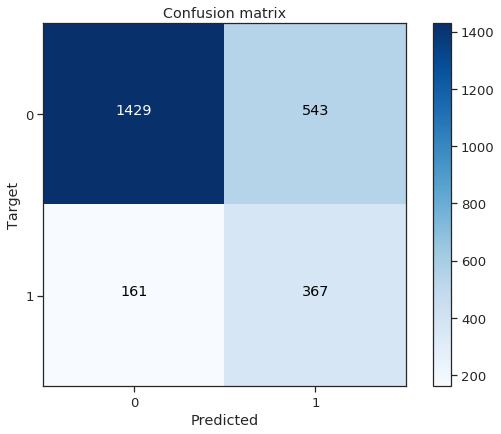

In [48]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, oversample_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Увеличение выборки не сильно повлияло на качество модели. AUC также практически не изменился. Попробуем пойти обратным путем и уменьшить выборку используя технику андерсемплинга.

**Андерсемплинг:**

In [49]:
%%time

undersample_pipeline = make_pipeline(RandomUnderSampler(random_state=321), 
                                     LogisticRegression(solver='liblinear',
                                                        penalty='l1', C=0.01,
                                                        random_state=456))

log_undersample_score = cross_validate(undersample_pipeline, features_train,
                                       target_train, scoring='f1', cv=5)

print("best cv f1-score: ", round(log_undersample_score['test_score'].max(), 2))

best cv f1-score:  0.5
CPU times: user 313 ms, sys: 462 ms, total: 775 ms
Wall time: 756 ms


Оценим эффективность модели на тестовой выборке.

In [50]:
%%time

undersample_predicted = undersample_pipeline.fit(features_train, target_train
                                                ).predict(features_test)
undersample_probas = undersample_pipeline.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, undersample_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, undersample_predicted), 2), auc_roc))

F1 = 0.50, AUC = 0.75
CPU times: user 66.1 ms, sys: 102 ms, total: 168 ms
Wall time: 120 ms


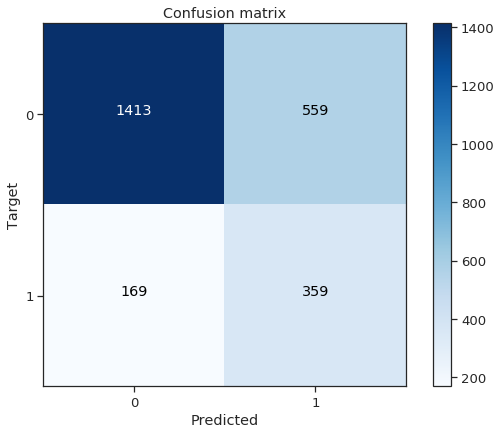

In [51]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, undersample_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Никак не получается добиться качества модели выше 0.51. Посмотрим, в предсказании классов каких объектов модель ошибается чаще всего, будем сравнивать модели сбалансированные разными способами.

In [52]:
# соберем в один датафрейм реальные значения целевого признака и все предсказания сбалансированных и несбалансированных моделей
problem_objects = pd.concat([target_test, 
                             pd.Series(disbalance_predicted, index=target_test.index),
                             pd.Series(balance_predicted, index=target_test.index),
                             pd.Series(oversample_predicted, index=target_test.index),
                             pd.Series(undersample_predicted, index=target_test.index)], axis=1)

problem_objects.columns = ['Exited', 'DisbalancePredicted', 'BalancePredicted',
                           'OversamplePredicted', 'UndersamplePredicted']

problem_objects

,Exited,DisbalancePredicted,BalancePredicted,OversamplePredicted,UndersamplePredicted
3074,1,1,1,1,1
2000,0,0,1,1,1
6604,0,0,0,1,1
1859,0,0,0,0,0
2170,0,0,0,0,0
...,...,...,...,...,...
4839,1,1,1,1,1
8687,0,0,1,1,1
5876,0,0,0,0,1
9364,0,0,1,1,1


In [53]:
# отфильтруем индексы объектов в определении которых модель ошибалась постоянно
problem_objects['Status'] = sum([problem_objects[x] == problem_objects['Exited']
                                 for x in problem_objects.iloc[:, 1:]]) == 0

problem_index = problem_objects.query("Status").index

In [54]:
# найдем объекты с класса 0, которые определились как класс 1 и рассмотрим их статистики
customer_churn_data.query("index in @problem_index and Exited == 0").describe()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,has_balance
count,74.000000,74.000000,70.000000,74.000000,74.000000,74.000000,74.000000,74.0,74.000000
mean,638.216216,63.567568,5.071429,1.513514,0.716216,0.662162,102815.312162,0.0,0.743243
std,109.550297,13.605077,2.793997,0.503229,0.453911,0.476201,62637.844435,0.0,0.439826
min,439.000000,38.000000,0.000000,1.000000,0.000000,0.000000,937.150000,0.0,0.000000
25%,547.500000,48.250000,3.000000,1.000000,0.000000,0.000000,48640.685000,0.0,0.250000
50%,640.000000,69.000000,5.000000,2.000000,1.000000,1.000000,103941.555000,0.0,1.000000
75%,721.000000,74.000000,7.000000,2.000000,1.000000,1.000000,164057.090000,0.0,1.000000
max,850.000000,82.000000,10.000000,2.000000,1.000000,1.000000,197444.690000,0.0,1.000000


In [55]:
# найдем объекты с класса 1, которые определились как класс 0 и рассмотрим их статистики
customer_churn_data.query("index in @problem_index and Exited == 1").describe()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,has_balance
count,122.000000,122.000000,110.000000,122.000000,122.000000,122.000000,122.000000,122.0,122.000000
mean,643.155738,34.549180,4.990909,1.516393,0.573770,0.622951,109017.474508,1.0,0.721311
std,97.107508,6.082222,2.656118,0.825559,0.496567,0.486646,59263.796216,0.0,0.450203
min,363.000000,18.000000,0.000000,1.000000,0.000000,0.000000,417.410000,1.0,0.000000
25%,581.500000,30.250000,3.000000,1.000000,0.000000,0.000000,55899.635000,1.0,0.000000
50%,648.000000,36.000000,5.000000,1.000000,1.000000,1.000000,114141.315000,1.0,1.000000
75%,708.750000,39.750000,7.000000,2.000000,1.000000,1.000000,155831.012500,1.0,1.000000
max,850.000000,44.000000,10.000000,4.000000,1.000000,1.000000,198402.370000,1.0,1.000000


Похоже модель относит к объектам класса "1" клиентов постарше с балансом выше среднего, но средним доходом. Как мы видели ранее, среди ушедших клиентов действительно больше возрастных с балансом выше среднего, но при этом зачастую менее активных (среднее 'IsActiveMember' = 0.36). К объектам класса "0" модель ошибочно относит более молодых клиентов с доходами чуть выше среднего. Возможно, стоит делать предсказания по оттоку клиентов в разных возрастных группах.

Распределение некоторых признаков внутри классов похоже, что говорит о том, что объекты редкого класса могут равномерно, но с низкой плотностью, распределяться среди объектов частого класса. Также некоторые признаки имеют слабую изменчивость, что является бесполезным для линейных моделей. Возможно стоит удалить некоторые менее характерные признаки из модели, чтобы она меньше путалась.

По гистограммам распределения некоторые признаки мне показались более характерными. Например, 'Age', 'NumOfProducts', 'IsActiveMember', 'Gender_Male' и может быть 'CreditScore' (т.к. среди тех у кого низкий кредитный рейтинг только ушедшие клиенты). Сверю свои предположения с результатами модуля ```feature_selection```. Попробую обучить модель на отобранных признаках.

In [56]:
# отберем минимальное, положительно влияющее на качество модели, кол-во признаков 
rfe = RFE(balance_model, 4)
rfe = rfe.fit(features_train, target_train)

for i in range(len(features_train.columns)):
    if rfe.support_[i]:
        print(features_train.columns[i])

Age
IsActiveMember
Geography_Germany
Gender_Male


Оценим эффективность модели на тестовой выборке.

In [57]:
%%time

feature_select_model = Pipeline([
    ('feature_selection', RFE(balance_model, 4)),
    ('classification', LogisticRegression(**log_random.best_params_,
                                          random_state=678))
])

feature_select_model.fit(features_train, target_train)
feature_select_predicted = feature_select_model.predict(features_test)
feature_select_probas = feature_select_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, feature_select_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, feature_select_predicted), 2), auc_roc))

F1 = 0.52, AUC = 0.77
CPU times: user 260 ms, sys: 41.8 ms, total: 302 ms
Wall time: 311 ms


После исключения из модели слабоинформативных признаков результат практически не изменился (+0.01). Возможно, зависимость в данных не получится описать лучше используя линейную модель, поэтому попробуем обратиться к моделям другого класса - "дерево решений" и "случайный лес".

Соберем все результаты в одну таблицу для удобства стравнения.

In [58]:
log_result = pd.DataFrame(data={
    'Logistic Regression':  round(f1_score(target_test, disbalance_predicted), 2),
    'Logistic Regression (balanced)': round(f1_score(target_test, balance_predicted), 2),
    'Logistic Regression (oversampling)': round(f1_score(target_test, oversample_predicted), 2),
    'Logistic Regression (undersampling)': round(f1_score(target_test, undersample_predicted), 2),
    'Logistic Regression (balanced, feature selection)': round(f1_score(target_test, feature_select_predicted), 2),
}, index=["F1-value"]).round(2)

log_result

,Logistic Regression,Logistic Regression (balanced),Logistic Regression (oversampling),Logistic Regression (undersampling),"Logistic Regression (balanced, feature selection)"
F1-value,0.32,0.5,0.51,0.5,0.52


### 3.2 "Дерево решений"

In [59]:
tree_model = DecisionTreeClassifier(random_state=135)

In [60]:
%%time

print("mean f1-score: {cv mean}, std: {std}".format(
    **get_cv_scores(tree_model, features_train, target_train)))

mean f1-score: 0.49, std: 0.01
CPU times: user 210 ms, sys: 1.22 ms, total: 211 ms
Wall time: 238 ms


Оценим эффективность модели на тестовой выборке.

In [61]:
%%time

tree_model.fit(features_train, target_train)
tree_predictions = tree_model.predict(features_test)
tree_probas = tree_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, tree_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    f1_score(target_test, tree_predictions), auc_roc))

F1 = 0.49, AUC = 0.68
CPU times: user 52.6 ms, sys: 3.72 ms, total: 56.3 ms
Wall time: 58.2 ms


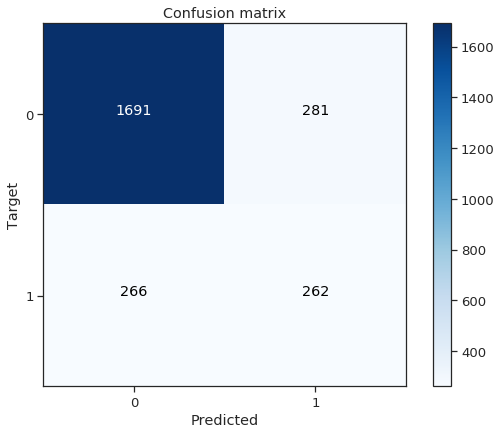

In [62]:
# матрица ошибок по предсказанию несбалансированной модели
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, tree_predictions)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Подберем гиперпараметры и сбалансируем модель.

In [63]:
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start=5, stop=15, num=5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
class_weight = ['balanced']

tree_grid = {'criterion': criterion,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'class_weight': class_weight
            }


print(tree_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [5, 7, 10, 12, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': ['balanced']}


In [64]:
tree_test_model = DecisionTreeClassifier(random_state=123)

In [65]:
tree_random = RandomizedSearchCV(estimator=tree_test_model, scoring='f1',
                                 param_distributions=tree_grid, verbose=2, refit='f1',
                                 random_state=123, n_jobs=-1)

tree_random.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=en

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced, total=   0.1s
[CV] min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] mi

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 7, 10, 12, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=123, refit='f1', scoring='f1', verbose=2)

In [66]:
print("best cv f1-score: ", round(tree_random.best_score_, 2))

best cv f1-score:  0.56


In [67]:
print("best params:")
tree_random.best_params_

best params:


{'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 7,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

Оценим эффективность модели на тестовой выборке.

In [68]:
%%time

tree_balance_model = DecisionTreeClassifier(random_state=321, **tree_random.best_params_
                                           ).fit(features_train, target_train)
tree_balance_predictions = tree_balance_model.predict(features_test)
tree_balance_probas = tree_balance_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, tree_balance_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    f1_score(target_test, tree_balance_predictions), auc_roc))

F1 = 0.57, AUC = 0.85
CPU times: user 47.9 ms, sys: 0 ns, total: 47.9 ms
Wall time: 77.9 ms


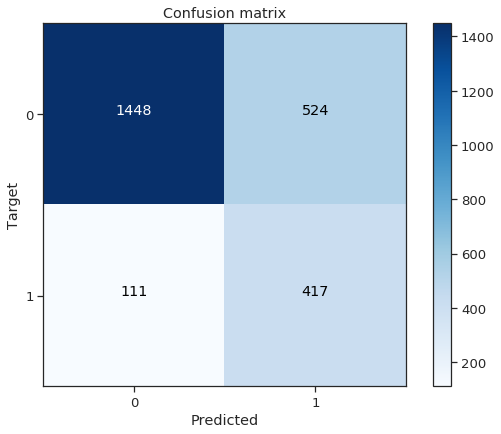

In [69]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, tree_balance_predictions)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Качество предсказаний положительного класса улучшилось, при этом количество ложноположительных объектов также увеличилось. Попробуем применить техники ресемплинга.

**Оверсемплинг:**

In [70]:
%%time

tree_oversample_pipeline = make_pipeline(RandomOverSampler(random_state=123), 
                                         DecisionTreeClassifier(min_samples_split=2,
                                                                min_samples_leaf=4,
                                                                max_depth=7,
                                                                criterion='entropy',
                                                                random_state=321)
                                        )

tree_oversample_score = cross_validate(tree_oversample_pipeline, features_train,
                                       target_train, scoring='f1', cv=5)

print("best cv f1-score: ", round(tree_oversample_score['test_score'].max(), 2))

best cv f1-score:  0.57
CPU times: user 291 ms, sys: 2.33 ms, total: 294 ms
Wall time: 303 ms


Оценим эффективность модели на тестовой выборке.

In [71]:
%%time

# оценим эффективность модели по ROC-AUC
tree_oversample_predicted = tree_oversample_pipeline.fit(features_train, target_train
                                                        ).predict(features_test)
tree_oversample_probas = tree_oversample_pipeline.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, tree_oversample_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, tree_oversample_predicted), 2), auc_roc))

F1 = 0.59, AUC = 0.85
CPU times: user 65 ms, sys: 3.8 ms, total: 68.8 ms
Wall time: 78.7 ms


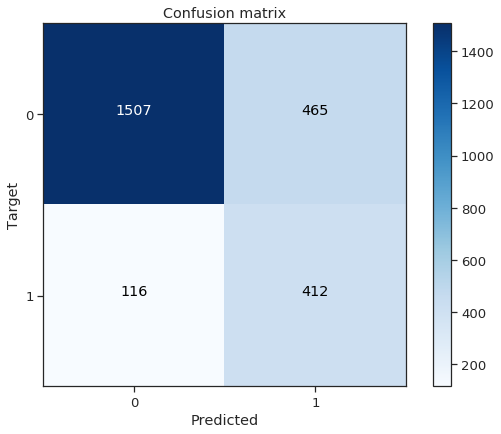

In [72]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, tree_oversample_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

**Андерсемплинг:**

In [73]:
%%time

tree_undersample_pipeline = make_pipeline(RandomUnderSampler(random_state=987),
                                          DecisionTreeClassifier(min_samples_split=2,
                                                                 min_samples_leaf=4,
                                                                 max_depth=7,
                                                                 criterion='entropy',
                                                                 random_state=789)
                                         )

tree_undersample_score = cross_validate(tree_undersample_pipeline, features_train,
                                        target_train, scoring='f1', cv=5)

print("best cv f1-score: ", round(tree_undersample_score['test_score'].max(), 2))

best cv f1-score:  0.55
CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 174 ms


Оценим эффективность модели на тестовой выборке.

In [74]:
%%time

# оценим эффективность модели по ROC-AUC
tree_undersample_predicted = tree_undersample_pipeline.fit(features_train, target_train
                                                          ).predict(features_test)
tree_undersample_probas = tree_undersample_pipeline.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, tree_undersample_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, tree_undersample_predicted), 2), auc_roc))

F1 = 0.58, AUC = 0.84
CPU times: user 33 ms, sys: 7.04 ms, total: 40 ms
Wall time: 50.4 ms


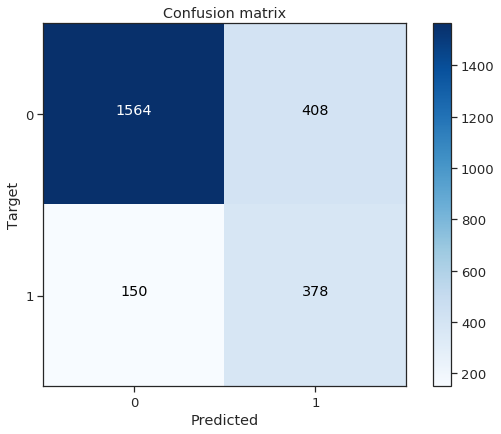

In [75]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, tree_undersample_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Сведем результаты обучения моделей в единую таблицу.

In [76]:
tree_result = pd.DataFrame(data={
    'Tree Classifier':  round(f1_score(target_test, tree_predictions), 2),
    'Tree Classifier (balanced)': round(f1_score(target_test, tree_balance_predictions), 2),
    'Tree Classifier (oversampling)': round(f1_score(target_test, tree_oversample_predicted), 2),
    'Tree Classifier (undersampling)': round(f1_score(target_test, tree_undersample_predicted), 2),
    'Tree Classifier (feature selection)': '-',
}, index=["F1-value"]).round(2)

tree_result

,Tree Classifier,Tree Classifier (balanced),Tree Classifier (oversampling),Tree Classifier (undersampling),Tree Classifier (feature selection)
F1-value,0.49,0.57,0.59,0.58,-


### 3.3 "Случайный лес"

Сначала обучим несбалансированную модель.

In [77]:
forest_model = RandomForestClassifier(random_state=359, n_jobs=-1)

In [78]:
%%time

print("mean f1-score: {cv mean}, std: {std}".format(
    **get_cv_scores(forest_model, features_train, target_train)))

mean f1-score: 0.56, std: 0.0179
CPU times: user 4.32 s, sys: 0 ns, total: 4.32 s
Wall time: 4.33 s


Оценим эффективность модели на тестовой выборке.

In [79]:
%%time

forest_model.fit(features_train, target_train)
forest_predictions = forest_model.predict(features_test)
forest_probas = forest_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, forest_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    f1_score(target_test, forest_predictions), auc_roc))

F1 = 0.59, AUC = 0.85
CPU times: user 1.14 s, sys: 1.65 ms, total: 1.14 s
Wall time: 1.16 s


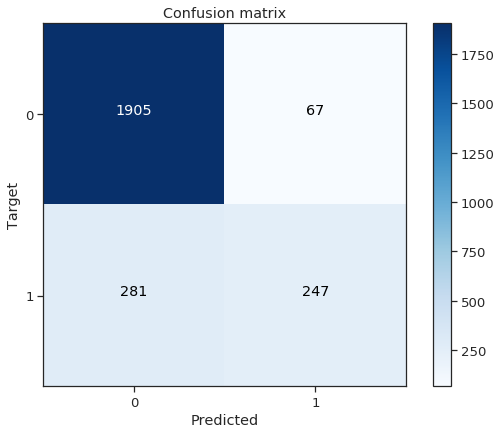

In [80]:
# матрица ошибок по предсказанию несбалансированной модели
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, forest_predictions)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Подберем гиперпараметры и сбалансируем модель.

In [81]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=3)]
max_depth = [int(x) for x in np.linspace(start=3, stop=12, num=5)]
criterion = ['gini', 'entropy']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

forest_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'criterion': criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight
              }


print(forest_grid)

{'n_estimators': [100, 150, 200], 'max_depth': [3, 5, 7, 9, 12], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample', None]}


In [82]:
forest_test_model = RandomForestClassifier(random_state=351)

In [83]:
forest_random = RandomizedSearchCV(estimator=forest_test_model, scoring='f1',
                                   param_distributions=forest_grid, verbose=2,
                                   refit='f1', random_state=123, n_jobs=-1)

forest_random.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False, total=   0.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False, total=   0.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False, total=   0.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False, total=   0.9s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=None, bootstrap=False, total=   0.9s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=351),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 9, 12],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200]},
                   random_state=123, refit='f1', scoring='f1', verbose=2)

In [84]:
print("best cv f1-score: ", round(forest_random.best_score_, 2))

best cv f1-score:  0.61


In [85]:
print("best params:")
forest_random.best_params_

best params:


{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 9,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'bootstrap': True}

Оценим эффективность модели на тестовой выборке.

In [86]:
%%time

forest_balance_model = RandomForestClassifier(random_state=325, **forest_random.best_params_
                                             ).fit(features_train, target_train)
forest_balance_predictions = forest_balance_model.predict(features_test)
forest_balance_probas = forest_balance_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, forest_balance_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    f1_score(target_test, forest_balance_predictions), auc_roc))

F1 = 0.63, AUC = 0.86
CPU times: user 1.3 s, sys: 6.51 ms, total: 1.3 s
Wall time: 1.33 s


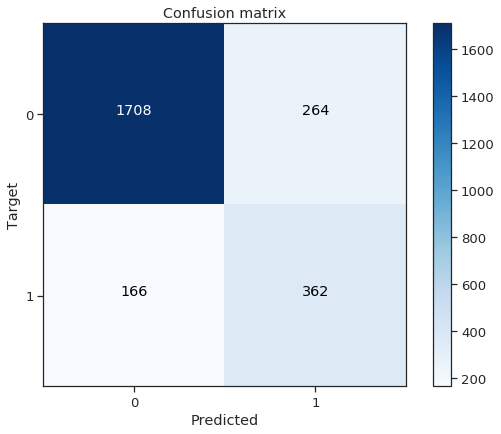

In [87]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, forest_balance_predictions)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

**Оверсемплинг:**

In [88]:
%%time

forest_oversample_pipeline = make_pipeline(RandomOverSampler(random_state=123), 
                                           RandomForestClassifier(n_estimators=150,
                                                                  min_samples_split=10,
                                                                  min_samples_leaf=4,
                                                                  max_depth=9,
                                                                  criterion='gini',
                                                                  bootstrap=True,
                                                                  n_jobs=-1,
                                                                  random_state=111)
                                        )

forest_oversample_score = cross_validate(forest_oversample_pipeline, features_train,
                                         target_train, scoring='f1', cv=5)

print("best cv f1-score: ", round(forest_oversample_score['test_score'].max(), 2))

best cv f1-score:  0.64
CPU times: user 7.29 s, sys: 7.84 ms, total: 7.3 s
Wall time: 7.42 s


Оценим эффективность модели на тестовой выборке.

In [89]:
%%time

forest_oversample_predicted = forest_oversample_pipeline.fit(features_train, target_train
                                                            ).predict(features_test)
forest_oversample_probas = forest_oversample_pipeline.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, forest_oversample_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, forest_oversample_predicted), 2), auc_roc))

F1 = 0.61, AUC = 0.86
CPU times: user 1.93 s, sys: 6.44 ms, total: 1.93 s
Wall time: 1.95 s


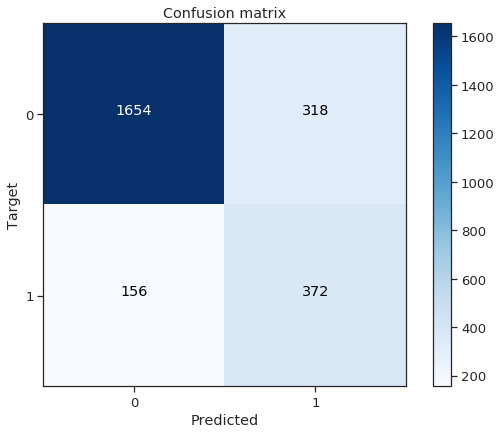

In [90]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, forest_oversample_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

**Андерсемплинг:**

In [91]:
%%time

forest_undersample_pipeline = make_pipeline(RandomUnderSampler(random_state=133),
                                            RandomForestClassifier(n_estimators=150,
                                                                   min_samples_split=10,
                                                                   min_samples_leaf=4,
                                                                   max_depth=9,
                                                                   criterion='gini',
                                                                   bootstrap=True,
                                                                   n_jobs=-1,
                                                                   random_state=311)
                                         )

forest_undersample_score = cross_validate(forest_undersample_pipeline, features_train,
                                          target_train, scoring='f1', cv=5)

print("best cv f1-score: ", round(forest_undersample_score['test_score'].max(), 2))

best cv f1-score:  0.62
CPU times: user 3.07 s, sys: 4.78 ms, total: 3.07 s
Wall time: 3.09 s


Оценим эффективность модели на тестовой выборке.

In [92]:
%%time

forest_undersample_predicted = forest_undersample_pipeline.fit(features_train, target_train
                                                              ).predict(features_test)
forest_undersample_probas = forest_undersample_pipeline.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, forest_undersample_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    round(f1_score(target_test, forest_undersample_predicted), 2), auc_roc))

F1 = 0.60, AUC = 0.86
CPU times: user 774 ms, sys: 3.37 ms, total: 777 ms
Wall time: 795 ms


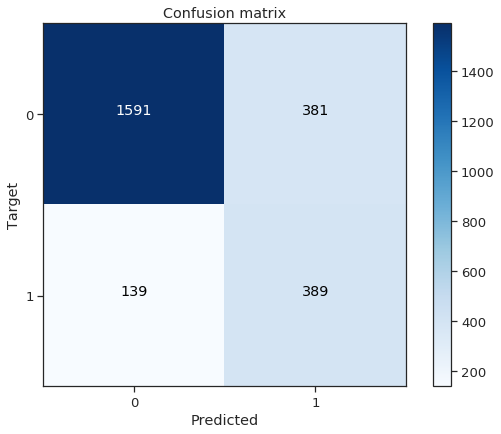

In [93]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
cnf_matrix_valid = confusion_matrix(target_test, forest_undersample_predicted)
plot_confusion_matrix(cnf_matrix_valid, classes=['0', '1'])

plt.show()

Соберем таблицу с результатами обученных моделей.

In [94]:
forest_result = pd.DataFrame(data={
    'Forest Classifier':  round(f1_score(target_test, forest_predictions), 2),
    'Forest Classifier (balanced)': round(f1_score(target_test, forest_balance_predictions), 2),
    'Forest Classifier (oversampling)': round(f1_score(target_test, forest_oversample_predicted), 2),
    'Forest Classifier (undersampling)': round(f1_score(target_test, forest_undersample_predicted), 2),
    'Forest Classifier (feature selection)': '-',
}, index=["F1-value"]).round(2)

forest_result

,Forest Classifier,Forest Classifier (balanced),Forest Classifier (oversampling),Forest Classifier (undersampling),Forest Classifier (feature selection)
F1-value,0.59,0.63,0.61,0.6,-


Алгоритмы дерево решений и случайный лес отработали лучше. Максимальное значение F1-меры составляет 0.63. Количество ложно-положительных объектов (ложных срабатываний) удалось снизить, но, как мы уже раньше говорили, для нас это менее критично, чем малое количество истинно-положительных объектов.

Сравним алгоритмы построив ROC-кривые.

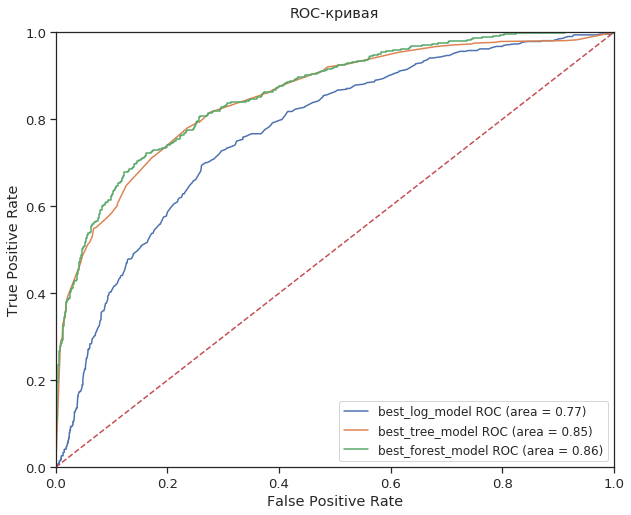

In [95]:
plt.figure(figsize=(10,8))

# сбалансированная весами модель логистической регрессии
fpr, tpr, thresholds = roc_curve(target_test, feature_select_probas[:, 1])
auc_roc = roc_auc_score(target_test, oversample_probas[:, 1])
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('best_log_model', auc_roc))

# сбалансированная оверсемплингом модель дерева решений
fpr, tpr, thresholds = roc_curve(target_test, tree_oversample_probas[:, 1])
auc_roc = roc_auc_score(target_test, tree_balance_probas[:, 1])
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('best_tree_model', auc_roc))

# сбалансированная весами модель слуйчайного леса
fpr, tpr, thresholds = roc_curve(target_test, forest_balance_probas[:, 1])
auc_roc = roc_auc_score(target_test, forest_balance_probas[:, 1])
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('best_forest_model', auc_roc))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая', pad=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

Используя алгоритм "случайный лес" удалось достичь значения F1-меры в 0.63. По ROC-кривой данный алгоритм также оказался лучшим - метрика AUC-ROC составляет 0.86.